# Portfolio Optimization

## Monte Carlo Simulation for Optimization Search


We could randomly try to find the optimal portfolio balance using Monte Carlo simulation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
from scipy.stats import norm,t

%matplotlib inline


# Import data
def getData(stocks, start, end):
    stockData = yf.download(stocks, start=start, end=end)
    stockData = stockData['Close']
    returns = np.log(stockData/stockData.shift(1))
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return returns, meanReturns, covMatrix

#
stockList = ['INFY', 'TCS', 'ITC', 'RELIANCE', 'HINDUNILVR', 'ALKEM', 'BATAINDIA']
tickers = [stock+'.NS' for stock in stockList]
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=800)   # Data for last 800 days

In [2]:
#Data for Portfolio optimisation

stocks_data = yf.download(tickers,startDate,endDate)
stocks_data = stocks_data['Close']
mean_daily_ret = stocks_data.pct_change().mean()

[*********************100%%**********************]  7 of 7 completed


# Simulating Thousands of Possible Allocations

In [3]:
#Normalisation of prices
stock_normed = stocks_data/stocks_data.iloc[0]
stock_daily_ret = stocks_data.pct_change(1)

#Calculating Log returns
log_ret = np.log(stocks_data/stocks_data.shift(1))

## Single Run for Some Random Allocation

In [4]:
stocks_data

Ticker,ALKEM.NS,BATAINDIA.NS,HINDUNILVR.NS,INFY.NS,ITC.NS,RELIANCE.NS,TCS.NS
Date,,,,,,,
2022-06-15,3101.000000,1722.300049,2146.550049,1422.199951,263.399994,2396.384033,3206.300049
2022-06-16,3051.350098,1677.800049,2146.699951,1397.199951,260.700012,2362.879150,3142.000000
2022-06-17,3098.350098,1636.599976,2110.449951,1387.300049,263.299988,2390.569092,3088.899902
2022-06-20,3118.199951,1628.900024,2195.899902,1414.150024,264.100006,2347.234375,3112.399902
2022-06-21,3075.699951,1658.349976,2205.000000,1449.900024,269.899994,2385.123535,3211.949951
...,...,...,...,...,...,...,...
2024-08-16,5681.950195,1421.150024,2748.250000,1858.949951,502.649994,2956.399902,4416.049805
2024-08-19,5740.700195,1425.050049,2742.550049,1864.800049,501.450012,2976.800049,4490.000000
2024-08-20,5733.049805,1419.250000,2751.050049,1872.199951,498.799988,2991.899902,4523.299805


### Now we will run this 15000 times

In [5]:
num_ports = 15000

all_weights = np.zeros((num_ports,len(stocks_data.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for ind in range(num_ports):

    # Create Random Weights
    weights = np.array(np.random.random(len(tickers)))

    # Rebalance Weights
    weights = weights / np.sum(weights)
    
    # Save Weights
    all_weights[ind,:] = weights

    # Expected Return
    ret_arr[ind] = np.sum((log_ret.mean() * weights) *252)

    # Expected std
    vol_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))

    # Sharpe Ratio
    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]

In [6]:
#Calculating global minimum variance

optimal_ret = ret_arr[sharpe_arr.argmax()]
optimal_vol = vol_arr[sharpe_arr.argmax()]
optiman_weights = all_weights[sharpe_arr.argmax()]
print(optimal_ret)
print(optimal_vol)
print(optiman_weights)

0.23570254906747287
0.1275178849913211
[0.19149116 0.00407388 0.08696159 0.01122002 0.38698985 0.00726683
 0.31199667]


## Plotting the data and adding Global Minimum Variance

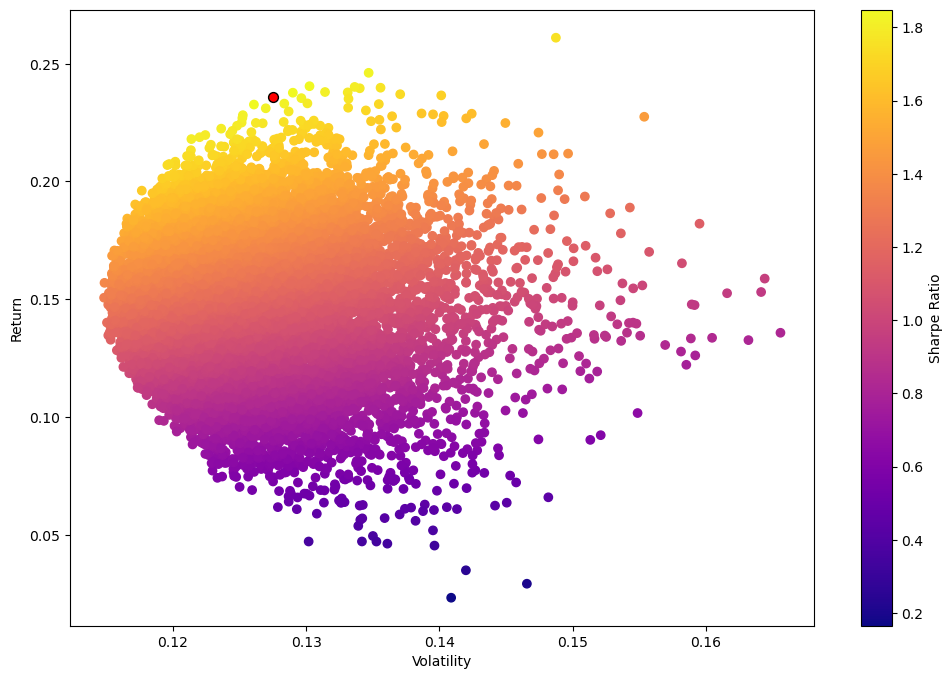

In [7]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
# Add red dot for max SR
plt.scatter(optimal_vol,optimal_ret,c='red',s=50,edgecolors='black')
plt.savefig('Port_optimisation',bbox_inches='tight')

In [10]:
# getting data for Var and expected shortfall calculation

# Portfolio Performance
def portfolioPerformance(weights, meanReturns, covMatrix, Time):
    returns = np.sum(meanReturns*weights)*Time
    std = np.sqrt( np.dot(weights.T, np.dot(covMatrix, weights)) ) * np.sqrt(Time)
    return returns, std

returns, meanReturns, covMatrix = getData(tickers, start=startDate, end=endDate)
returns = returns.dropna()
GMV_weights = all_weights[vol_arr.argmin()]
weights = GMV_weights
returns['Portfolio'] = returns.dot(weights)
alpha = 5

[*********************100%%**********************]  7 of 7 completed


## Calculation of VaR and expected shortfall

In [11]:
#Historical method

#VaR 
def historicalVaR(returns,alpha=5):
    """
    Read in the pandas series of returns
    Output the percentile of the distribution at given alpha confidence level 
    """
    if isinstance(returns,pd.Series):
        return np.percentile(returns,alpha)
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalVaR,alpha=5)
    else:
        raise TypeError('Expected returns to be dataframe or series')
        
        
# Expected shortfall
def historicalCVaR(returns,alpha=5):
    """
    Read in the pandas series of returns
    Output the percentile of the distribution at given alpha confidence level 
    """
    if isinstance(returns,pd.Series):
        belowVaR = returns <= historicalVaR(returns,alpha=alpha)
        return returns[belowVaR].mean()
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalCVaR,alpha=5)
    else:
        raise TypeError('Expected returns to be dataframe or series')
        
#1day
Time = 1

VaR = -historicalVaR(returns['Portfolio'],alpha=5)
CVaR = -historicalCVaR(returns['Portfolio'], alpha=5)
pRet, pStd = portfolioPerformance(weights,meanReturns,covMatrix,Time)

        

    
#Parametric

#VaR
def var_parametric(portofolioReturns, portfolioStd, distribution='normal', alpha=5, dof=6):
    # because the distribution is symmetric
    if distribution == 'normal':
        VaR = norm.ppf(1-alpha/100)*portfolioStd - portofolioReturns
    elif distribution == 't-distribution':
        nu = dof
        VaR = np.sqrt((nu-2)/nu) * t.ppf(1-alpha/100, nu) * portfolioStd - portofolioReturns
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return VaR

#Expected Shortfall
def cvar_parametric(portofolioReturns, portfolioStd, distribution='normal', alpha=5, dof=6):
    if distribution == 'normal':
        CVaR = (alpha/100)**-1 * norm.pdf(norm.ppf(alpha/100))*portfolioStd - portofolioReturns
    elif distribution == 't-distribution':
        nu = dof
        xanu = t.ppf(alpha/100, nu)
        CVaR = -1/(alpha/100) * (1-nu)**(-1) * (nu-2+xanu**2) * t.pdf(xanu, nu) * portfolioStd - portofolioReturns
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return CVaR
        
normVaR = var_parametric(pRet,pStd)
normCVaR = cvar_parametric(pRet,pStd)
tVaR = var_parametric(pRet, pStd, distribution='t-distribution')
tCVaR = cvar_parametric(pRet, pStd, distribution='t-distribution')






#VaR and Expected shotfall Calculation

InitialInvestment = 1000000
print ("\033[1m" + "VaR and CVaR Historical Method" + "\033[0m")
print('Expected port ret: ', round(pRet*InitialInvestment,2))
print('VaR at Risk 95th CI: ', round(VaR*InitialInvestment,2))
print('Conditional VaR 95th CI: ', round(CVaR*InitialInvestment,2))
print('\n')

print ("\033[1m" + "VaR and CVaR Parametric Method" + "\033[0m")
print('normal VaR 95th CI: ',round(InitialInvestment*normVaR,2))
print('normal CVaR 95th CI: ',round(InitialInvestment*normCVaR,2))
print('t-dist VaR 95th CI: ',round(InitialInvestment*tVaR,2))
print('t-dist CVaR 95th CI: ',round(InitialInvestment*tCVaR,2))
print('\n')


VaR and CVaR Historical Method
Expected port ret:  597.84
VaR at Risk 95th CI:  11422.99
Conditional VaR 95th CI:  15574.65


VaR and CVaR Parametric Method
normal VaR 95th CI:  11301.1
normal CVaR 95th CI:  14323.92
t-dist VaR 95th CI:  10879.7
t-dist CVaR 95th CI:  14999.96


